In [6]:
import matplotlib.pyplot as plt

from markovBike.manager.manager import Manager
from markovBike.data_source.source import database_queries, get_stations_data, get_trips_data
from markovBike.data_source.preprocess import preprocess_stations_data, preprocess_trips_data

import pandas as pd
import numpy as np

In [7]:
verbose = True

n_stations = 2_000

n_trips = 50_000_000


def calculate_probability_matrix_test(dataframe):
    # Drop rows with NaN values
    dataframe = dataframe.dropna()

    # Get a list of all unique station IDs
    station_ids = list(
        set(dataframe['start_station_id']) | set(dataframe['end_station_id']))

    # Initialize a square matrix with zeros
    num_stations = len(station_ids)
    probability_matrix = np.zeros((num_stations, num_stations))

    # Fill in the probability matrix with transition counts
    for _, row in dataframe.iterrows():
        start_station_id = row['start_station_id']
        end_station_id = row['end_station_id']
        start_station_index = station_ids.index(start_station_id)
        end_station_index = station_ids.index(end_station_id)
        probability_matrix[start_station_index][end_station_index] += 1

    # Convert the transition counts to transition probabilities
    total_trips = probability_matrix.sum(axis=1)
    probability_matrix /= total_trips[:, np.newaxis]

    # Convert to a pandas DataFrame and add row and column labels
    probability_matrix = pd.DataFrame(probability_matrix,
                                      index=station_ids,
                                      columns=station_ids)

    return probability_matrix


def calculate_probability_matrix(dataframe):
    # Get a list of all unique station IDs
    station_ids = dataframe[['start_station_id',
                             'end_station_id']].stack().unique()

    # Create an empty matrix to store trip counts
    trip_counts = np.zeros((len(station_ids), len(station_ids)))

    # Loop over each row in the DataFrame and update the corresponding entry in the trip counts matrix
    for _, row in dataframe.iterrows():
        start_station_id = row['start_station_id']
        end_station_id = row['end_station_id']
        start_index = np.where(station_ids == start_station_id)[0][0]
        end_index = np.where(station_ids == end_station_id)[0][0]
        trip_counts[start_index, end_index] += 1

    # Calculate the total number of trips from each station
    total_trips = trip_counts.sum(axis=1)

    # Calculate the probability matrix
    probability_matrix = trip_counts / total_trips[:, np.newaxis]

    # Fill NaN values with zeros
    probability_matrix = np.nan_to_num(probability_matrix)

    # Convert to a pandas DataFrame and add row and column labels
    probability_matrix = pd.DataFrame(probability_matrix,
                                      index=station_ids,
                                      columns=station_ids)

    return probability_matrix

Bike station table with shape (500000, 15). Columns are: 

tripduration                             Int64
starttime                  datetime64[ns, UTC]
stoptime                   datetime64[ns, UTC]
start_station_id                         Int64
start_station_name                      object
start_station_latitude                 float64
start_station_longitude                float64
end_station_id                           Int64
end_station_name                        object
end_station_latitude                   float64
end_station_longitude                  float64
bikeid                                   Int64
usertype                                object
birth_year                               Int64
gender                                  object
dtype: object


/var/folders/70/pdzh2d9d281f_ylgth2bn0z80000gn/T/ipykernel_11248/28259835.py:60: RuntimeWarning: invalid value encountered in divide
  probability_matrix = trip_counts / total_trips[:, np.newaxis]


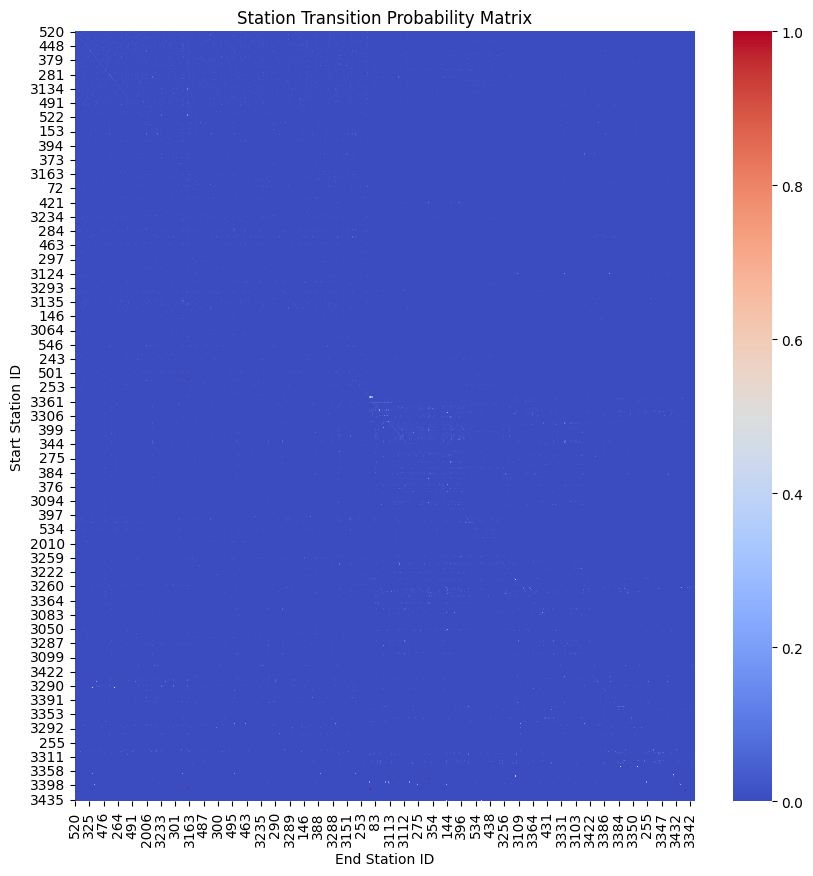

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

trips_raw = get_stations_data(database_queries(n_trips)['trips'], verbose=True)

# Call the calculate_probability_matrix function to get the probability matrix
probability_matrix = calculate_probability_matrix(trips_raw)

# Plot a heatmap of the probability matrix
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(probability_matrix, cmap='coolwarm', ax=ax)

ax.set_title('Station Transition Probability Matrix')
ax.set_xlabel('End Station ID')
ax.set_ylabel('Start Station ID')

plt.show()